In [1]:
import pandas as pd
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime as dt
import re
from sklearn.model_selection import KFold
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as LGBM
from scipy.stats import ttest_ind
import scipy as sp
import scipy.stats as stats
import shap
import gc
import os
import glob
import sys
import pickle
import warnings
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/Colab Notebooks/NBA Pred/Data'

warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 100)


csv_files = glob.glob(os.path.join(folder_path, '*.csv'))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dict_teams = {'Utah Jazz':'UTA','Phoenix Suns':'PHO',
             'Philadelphia 76ers':'PHI','Brooklyn Nets':'BRK',
             'Denver Nuggets':'DEN','Los Angeles Clippers':'LAC',
             'Milwaukee Bucks':'MIL','Dallas Mavericks':'DAL',
             'Los Angeles Lakers':'LAL','Portland Trail Blazers':'POR',
             'Atlanta Hawks':'ATL','New York Knicks':'NYK',
             'Miami Heat':'MIA','Golden State Warriors':'GSW',
             'Memphis Grizzlies':'MEM','Boston Celtics':'BOS',
             'Washington Wizards':'WAS','Indiana Pacers':'IND',
             'Charlotte Hornets':'CHO','Charlotte Bobcats':'CHA',
             'San Antonio Spurs':'SAS','Chicago Bulls':'CHI',
             'New Orleans Pelicans':'NOP','Sacramento Kings':'SAC',
             'Toronto Raptors':'TOR','Minnesota Timberwolves':'MIN',
             'Cleveland Cavaliers':'CLE','Oklahoma City Thunder':'OKC',
             'Orlando Magic':'ORL','Detroit Pistons':'DET',
             'Houston Rockets':'HOU','New Jersey Nets':'NJN',
             'New Orleans Hornets':'NOH','Seattle SuperSonics':'SEA',
              'Vancouver Grizzlies':'VAN','Washington Bullets':'WSB',
              'Kansas City Kings':'KCK','San Diego Clippers':'SDC'}


all_dfs = []

In [3]:
for file in csv_files:
    try:
        year_match = re.search(r'(\d{4})', os.path.basename(file))
        year = int(year_match.group(1)) if year_match else None
        temp_df = pd.read_csv(file, sep=';', decimal=',', encoding='latin-1')


        temp_df['Year'] = year

        all_dfs.append(temp_df)
    except Exception as e:
        print(f"Error processing file {file}: {e}")

# Combine all cleaned DataFrames
df = pd.concat(all_dfs, ignore_index=True).drop_duplicates().reset_index(drop=True)

# Save combined DataFrame as BASE_FINAL.csv
output_path = os.path.join(folder_path, 'BASE_FINAL.csv')
df.to_csv(output_path, sep=';', decimal=',', encoding='latin-1', index=False)


print(f"\n✅ Saved cleaned and combined data to: {output_path}")
print(f"Final DataFrame shape: {df.shape}")


✅ Saved cleaned and combined data to: /content/drive/My Drive/Colab Notebooks/NBA Pred/Data/BASE_FINAL.csv
Final DataFrame shape: (1771, 89)


In [4]:
display(df)
print(df.columns.tolist())

df = df.dropna(subset=['Year', 'Tm']).copy()



,Tm,W/L%,PS/G,PA/G,SRS,Seed,Rank_PS/G,Rank_PA/G,Rank_SRS,COACHES_Seasons_Franchise,...,Rank_ORtg,Rank_DRtg,Rank_NRtg,Rank_MOV/A,Rank_ORtg/A,Rank_DRtg/A,Rank_NRtg/A,Year,"Season,Tm,Playoff Wins,Wins Needed","Rk,Season,Lg,Age,Ht,Wt,G,MP,FG,FGA,3P,3PA,FT,FTA,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,FG%,3P%,FT%,Pace,eFG%,TOV%,ORB%,FT/FGA,ORtg,TS%"
0,OKC,0.829,120.5,107.6,12.70,1.0,4.0,3.0,1.0,5.0,...,3.0,1.0,1.0,1.0,3.0,1.0,1.0,2025,NaN,NaN
1,CLE,0.780,121.9,112.4,8.81,2.0,1.0,11.0,2.0,1.0,...,1.0,8.0,2.0,2.0,1.0,8.0,2.0,2025,NaN,NaN
2,BOS,0.744,116.3,107.2,8.28,3.0,8.0,2.0,3.0,3.0,...,2.0,5.0,3.0,3.0,2.0,7.0,3.0,2025,NaN,NaN
3,HOU,0.634,114.3,109.8,4.97,4.0,12.0,6.0,5.0,2.0,...,13.0,4.0,7.0,5.0,13.0,4.0,6.0,2025,NaN,NaN
4,NYK,0.622,115.8,111.7,3.59,5.0,9.0,9.0,9.0,5.0,...,5.0,13.0,8.0,9.0,5.0,15.0,9.0,2025,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766,ORL,0.305,NaN,NaN,NaN,26.0,21.0,17.0,25.0,1.0,...,27.0,24.0,26.0,26.0,27.0,25.0,26.0,None,NaN,NaN
1767,LAL,0.256,NaN,NaN,NaN,27.0,16.0,22.0,26.0,1.0,...,24.0,29.0,27.0,27.0,24.0,28.0,27.0,None,NaN,NaN
1768,PHI,0.220,NaN,NaN,NaN,28.0,25.0,15.0,28.0,2.0,...,30.0,13.0,28.0,29.0,30.0,14.0,29.0,None,NaN,NaN
1769,NYK,0.207,NaN,NaN,NaN,29.0,26.0,16.0,29.0,1.0,...,29.0,28.0,30.0,30.0,28.0,29.0,30.0,None,NaN,NaN


['Tm', 'W/L%', 'PS/G', 'PA/G', 'SRS', 'Seed', 'Rank_PS/G', 'Rank_PA/G', 'Rank_SRS', 'COACHES_Seasons_Franchise', 'COACHES_Seasons_Career', 'COACHES_RS_CA_W%', 'COACHES_RS_S_PCT', 'COACHES_RS_FR_PCT', 'COACHES_RS_CA_PCT', 'COACHES_PL_FR_PCT', 'COACHES_PL_CA_PCT', 'Age', 'ALL_STAR', 'Top3_PTS', 'Top10_PTS', 'Top30_PTS', 'Top3_AST', 'Top10_AST', 'Top30_AST', 'Top3_REB', 'Top10_REB', 'Top30_REB', 'Top3_FG', 'Top10_FG', 'Top30_FG', 'Top3_FG%', 'Top10_FG%', 'Top30_FG%', 'Top3_3P', 'Top10_3P', 'Top30_3P', 'Top3_3P%', 'Top10_3P%', 'Top30_3P%', 'Top3_FT', 'Top10_FT', 'Top30_FT', 'Top3_FT%', 'Top10_FT%', 'Top30_FT%', 'Top3_STL', 'Top10_STL', 'Top30_STL', 'Top3_BLK', 'Top10_BLK', 'Top30_BLK', 'Top3_PER', 'Top10_PER', 'Top30_PER', 'Top3_WS', 'Top10_WS', 'Top30_WS', 'Top3_WS/48', 'Top10_WS/48', 'Top30_WS/48', 'Top3_VORP', 'Top10_VORP', 'Top30_VORP', 'Top3_BPM', 'Top10_BPM', 'Top30_BPM', 'Top3_USG%', 'Top10_USG%', 'Top30_USG%', 'MOV', 'ORtg', 'DRtg', 'NRtg', 'MOV/A', 'ORtg/A', 'DRtg/A', 'NRtg/A', 'R

In [5]:
df = df.rename(columns={'Year': 'Season'})
dupes = df[df.duplicated(subset=['Tm', 'Season'], keep=False)]
print(dupes[['Tm', 'Season']].value_counts())

Series([], Name: count, dtype: int64)


In [6]:
sep = '/'

# Only keep rows with standard 3-letter team abbreviations
df = df[df['Tm'].str.len() == 3]

# Filter out teams with missing player-level info
df = df[df['Top10_PTS'].notna()]

# Load playoff results
champions = pd.read_csv(folder_path + sep + 'champions.csv', sep=',', encoding='latin-1')
champions = champions.dropna(subset=['Season', 'Tm']).copy()

# Match team names if needed
champions['Tm'] = champions['Tm'].replace(dict_teams)

# Calculate the share of total playoff wins relative to wins needed to win the championship for each year
champions['Playoff Share'] = champions['Playoff Wins'] / champions['Wins Needed']
champions = champions.rename(columns={'Playoff Share': 'CLASSE'})

# Filter out missing values just in case any are left
champions = champions[champions['CLASSE'].notna()]

# Merge `CLASSE` values back into main dataset

df = df.merge(champions[['Tm', 'Season', 'CLASSE']], on=['Tm', 'Season'], how='left', validate='1:1').fillna(0)


# Sort
df = df.sort_values(['Tm', 'Season']).reset_index(drop=True)

# Feature: CLASSE
df['Champion_Share_Previous_Season'] = df.groupby('Tm')['CLASSE'].shift(1).fillna(0)

#Rolling average CLASSE over the last 3 seasons
df['Champion_Share_Last_3_Seasons'] = (
    df
    .groupby('Tm', group_keys=False)
    .apply(lambda g: g['CLASSE'].shift(1).rolling(window=3, min_periods=1).mean())
    .reset_index(drop=True)
).fillna(0)

# Optional: Save this cleaned dataset to disk
#df.to_csv(path_save + sep + 'BASE_FINAL.csv', sep=';', decimal=',', encoding='latin-1', index=False)


In [7]:
features = [
    'Seed', 'W/L%', 'Rank_NRtg', 'Rank_PA/G', 'Rank_MOV', 'Rank_ORtg/A', 'Top30_BPM', 'Top3_WS/48'

]

X = df[features]


In [12]:
seasons_train = df[df['Season'] < 2023]['Season'].unique().tolist()
seasons_test = [2023, 2024]

# Create train/test sets
train_df = df[df['Season'].isin(seasons_train)].copy()
test_df = df[df['Season'].isin(seasons_test)].copy()

In [13]:
drop_cols = ['CLASSE', 'Season', 'Tm']
X_train = train_df[features]
y_train = train_df['CLASSE']

X_test = test_df[features]
y_test = test_df['CLASSE']

X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

In [14]:
import lightgbm


In [15]:
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_squared_error, r2_score



model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, verbose=100)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', callbacks=[early_stopping(stopping_rounds=50)])

# Predict
y_pred = model.predict(X_test)
test_df['predicted_CLASSE'] = y_pred

from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.153646
[LightGBM] [Debug] init for col-wise cost 0.000005 seconds, init for row-wise cost 0.000143 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 240, number of used features: 8
[LightGBM] [Info] Start training from score 0.173177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 7 and depth = 4
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 6
[LightGBM] [Warning] No further spli

In [16]:
import pandas as pd
import joblib

final_4_teams = ['NYK', 'IND', 'MIN', 'OKC']
df_2025 = df[(df['Season'] == 2025) & (df['Tm'].isin(final_4_teams))].copy()

assert set(df_2025['Tm']) == set(final_4_teams), "Make sure 2025 data for all 4 teams is present"
features = [
    'Seed', 'W/L%', 'Rank_NRtg', 'Rank_PA/G', 'Rank_MOV', 'Rank_ORtg/A', 'Top30_BPM', 'Top3_WS/48'
]



X_2025 = df_2025[features]
pred_2025 = model.predict(X_2025)


results_2025 = pd.DataFrame({
    'Team': df_2025['Tm'],
    'Predicted_Championship_Score': pred_2025
})


results_2025 = results_2025.sort_values('Predicted_Championship_Score', ascending=False).reset_index(drop=True)




In [17]:
print("Predicted 2025 NBA Championship Likelihood Scores:")
print(results_2025)

Predicted 2025 NBA Championship Likelihood Scores:
  Team  Predicted_Championship_Score
0  OKC                      0.431821
1  IND                      0.392861
2  NYK                      0.392861
3  MIN                      0.198109


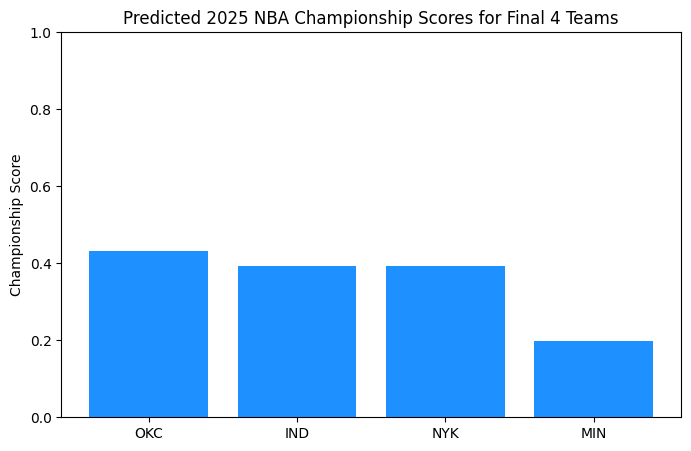

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(results_2025['Team'], results_2025['Predicted_Championship_Score'], color='dodgerblue')
plt.title('Predicted 2025 NBA Championship Scores for Final 4 Teams')
plt.ylabel('Championship Score')
plt.ylim(0, 1)
plt.show()

In [ ]:
def match_team_name(team_name):
    mapping = {
        'NY': 'New York Knicks',
        'IND': 'Indiana Pacers',
        'MIN': 'Minnesota Timberwolves',
        'OK': 'Oklahoma City Thunder'
    }
    return mapping.get(team_name, team_name)